# Отчет по лабораторной работе 4
## Неполнодоступная двухсервисная модель Эрланга с резервированием для заявок второго типа и разными интенсивностями обслуживания. Первыми заполняются зарезервированные приборы.

Генералов Даниил, 1032212280

Рассматривается неполнодоступная двухсервисная модель Эрланга с разными интенсивностями
обслуживания и резервированием для обслуживания запросов на предоставление услуги 2-го типа.
Запросы на предоставление услуги 2-го типа сначала заполняют
зарезервированную емкость.

-  $C$ -- общее число приборов;
-  $g$ -- число полнодоступных приборов;
- $C-g$ -- число зарезервированных приборов;
-  $\lambda_1$, $\lambda_2$ -- интенсивность поступления запросов 1, 2-го типа;
-  $\mu^{-1}$ -- среднее время обслуживания запроса 1, 2-го типа;
-  $\rho_1$, $\rho_2$ -- интенсивность предложенной нагрузки, создаваемой запросами 1, 2-го типа;
-  $X(t)$  --   число запросов, обслуживаемых в системе в  момент времени $t$, $t \geq 0$;
-  $X$ -- пространство состояний системы;
-  $n$ -- число обслуживаемых в системе запросов;
-  $B_1$, $B_2$ -- множество блокировок запросов 1, 2-го типа;
-  $S_1$, $S_2$ -- множество приема запросов 1, 2-го типа.

## 1. подключение библиотек, определение функций

Для расчета больших факториалов нам потребуется длинная арифметика, а для рисования графиков -- библиотека для визуализации данных.

In [3]:
:dep num = { version = "^0.4.3" }
:dep plotters = { version = "^0.3.6", default-features = false, features = ["evcxr", "all_series", "all_elements"] }

extern crate num;
use num::BigRational as R;
use num::BigInt as I;
use num::BigUint as U;
use num::Integer;
use num::traits::ConstZero;
use num::FromPrimitive;
use num::ToPrimitive;

extern crate plotters;
use plotters::prelude::*;

Для удобства конвертации стандартных чисел в числа длинной арифметики используются helper-функции.

In [4]:
fn u(i: usize) -> U {
    U::from_usize(i).unwrap()
}

fn rr(i: f64) -> R {
    R::from_float(i).unwrap()
}

Для вычисления факториала нет стандартной функции, и очевидные подходы не работают с длинной арифметикой, поэтому эта функция считает это за нас.

In [5]:
fn factorial(n: &U) -> R {
    let mut c = n.clone();
    let one = I::from_i8(1).unwrap();
    let mut out = R::new(one.clone(), one.clone());
    while c > U::ZERO {
        out *= R::new(I::from_biguint(num::bigint::Sign::Plus, c.clone()), one.clone());
        c -= 1u32;
    }
    out
}

Эта функция возвращает список, состоящий из только уникальных значений в указанном списке. Это нужно для того, чтобы упростить вычисление набора состояний.

In [6]:
fn make_unique<T: Eq + std::hash::Hash>(v: Vec<T>) -> Vec<T> {
    let mut set = std::collections::HashSet::new();
    for x in v {
        set.insert(x);
    }
    set.into_iter().collect()
}

Эта функция отображает график функции, принимая на вход список X-Y пар.

In [7]:
fn draw_chart(data: &Vec<(f32, f32)>, name: impl ToString) -> plotters::evcxr::SVGWrapper {
    let minx = data.iter().min_by(|a, b| a.0.partial_cmp(&b.0).unwrap_or(std::cmp::Ordering::Equal)).unwrap().0;
    let maxx = data.iter().max_by(|a, b| a.0.partial_cmp(&b.0).unwrap_or(std::cmp::Ordering::Equal)).unwrap().0;
    let miny = data.iter().min_by(|a, b| a.1.partial_cmp(&b.1).unwrap_or(std::cmp::Ordering::Equal)).unwrap().1;
    let maxy = data.iter().max_by(|a, b| a.1.partial_cmp(&b.1).unwrap_or(std::cmp::Ordering::Equal)).unwrap().1;
    let figure = evcxr_figure((640, 480), |root| {
        root.fill(&WHITE)?;
        let mut chart = ChartBuilder::on(&root)
            .caption(name.to_string(), ("Arial", 50).into_font())
            .margin(5)
            .x_label_area_size(30)
            .y_label_area_size(30)
            .build_cartesian_2d(minx..maxx, miny..maxy)?;

        chart.configure_mesh().draw()?;

        chart.draw_series(LineSeries::new(
            data.clone(),
            &RED,
        )).unwrap();

        // chart.configure_series_labels()
        //     .background_style(&WHITE.mix(0.8))
        //     .border_style(&BLACK)
        //     .draw()?;
        Ok(())
    });
    return figure;
}


# 2. входные параметры

Здесь задаются параметры, которые определяют модель.
Чтобы попробовать запустить вычисления с другими значениями, вы можете поменять эту ячейку и перезапустить ее и все ячейки ниже.

При разработке я использовал следующие значения для теста:

- $C = 4$
- $g = 3$
- $\rho_1 = \frac{1}{2}$
- $\rho_2 = 1$
- $\mu = 10$

In [8]:
let C = 4;
let g = 3;
let rho_1 = 0.5;
let rho_2 = 1.0;

let mu1 = 10.0;

# 3. вычисления

Для того, чтобы определить набор состояний, мы рассматриваем все возможные пары $(x, y) \geq (0,0)$, где $x+y \leq C$ и $n_1 \leq g$.
Этот цикл находит их и сохраняет в список.

In [9]:
println!("X = (n1, n2): n1 = 0,{g}, n2=0,{C}, n1+n2 <= {C}");
let mut states = vec![];
for n1 in 0..=g {
    for n2 in 0..=C {
        if n1 + n2 <= C {
            states.push((n1, n2));
        }
    }
}
println!("|X| = {}", states.len());

X = (n1, n2): n1 = 0,3, n2=0,4, n1+n2 <= 4
|X| = 14


Для того, чтобы показать набор состояний, мы должны нарисовать граф,
который содержит все состояния в наборе X,
и имеет соединения между соседними ячейками.
Этот код формирует такой граф,
затем визуализирует его через Graphviz,
и затем показывает в виде картинки.

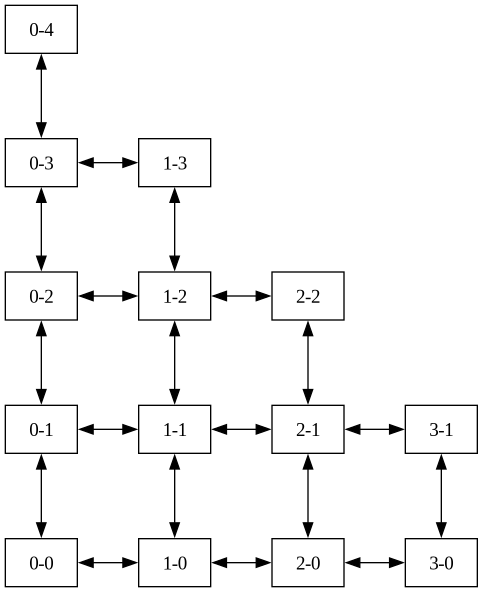

In [10]:
:dep graphviz-rust = { version = "^0.9.0" }
:dep base64 = { version = "^0.22.1" }
use base64::prelude::*;

let mut dot_graph = String::new();

dot_graph.push_str("graph G {\n");
dot_graph.push_str("  rankdir=LR;\n");
dot_graph.push_str("  layout=nop;\n");
dot_graph.push_str("  node [shape=box];\n");

for (n1, n2) in states.iter() {
    dot_graph.push_str(&format!("S{}_{} [label=\"{}-{}\", pos=\"{:.1}, {:.1}\"]\n", n1, n2, n1, n2, n1 * 100, n2 * 100));
    let (n1, n2) = (*n1, *n2);
    if states.contains(&(n1+1, n2)) {
        dot_graph.push_str(&format!("S{}_{} -- S{}_{} [dir=both]\n", n1, n2, n1+1, n2));
    }
    if states.contains(&(n1, n2+1)) {
        dot_graph.push_str(&format!("S{}_{} -- S{}_{} [dir=both]\n", n1, n2, n1, n2+1));
    }
}

dot_graph.push_str("}\n");


let png = graphviz_rust::exec_dot(dot_graph, vec![graphviz_rust::cmd::Format::Png.into()]).unwrap();
let png_base64 = BASE64_STANDARD.encode(&png);
println!("EVCXR_BEGIN_CONTENT image/png\n{}\nEVCXR_END_CONTENT", png_base64);

Состояния блокировки заявок -- это те, находясь в которых, система не может принять больше заявок первого или второго типов.
Для обоих типов заявок таковыми являются те, когда общее количество заявок равно $C$ (тогда даже приоритетные заявки нельзя обработать),
но для заявок первого типа -- есть еще ситуация, когда заняты все выделенные слоты (когда количество заявок $n_1 = g$).

In [11]:
// boundary states
let mut b1 = vec![];
let mut b2 = vec![];
for (n1, n2) in states.iter().cloned() {
    if n1 == g {
        b1.push((n1, n2));
    }
    if n1 + n2 == C {
        b1.push((n1, n2));
        b2.push((n1, n2));
    }
}
let b1 = make_unique(b1);
let b2 = make_unique(b2);
println!("B1 = (n1, n2) \\in X: n1 = {g} \\lor n1 + n2 = {C} = {b1:?}");
println!("B2 = (n1, n2) \\in X: n1 + n2 = {C} = {b2:?}");

B1 = (n1, n2) \in X: n1 = 3 \lor n1 + n2 = 4 = [(3, 1), (3, 0), (0, 4), (1, 3), (2, 2)]
B2 = (n1, n2) \in X: n1 + n2 = 4 = [(1, 3), (0, 4), (2, 2), (3, 1)]


Множество приема запросов -- это обратное множество к множеству блокировки: $S_i = X \setminus B_i$.
Здесь мы вычисляем его именно так, но также есть способ написать обратную формулу к формуле определения множества блокировки.

In [12]:
// interior states
let mut s1 = vec![];
let mut s2 = vec![];
for s in states.iter() {
    if !b1.contains(s) {
        s1.push(*s);
    }
    if !b2.contains(s) {
        s2.push(*s);
    }
}

println!("S1 = (n1, n2) \\in X: n1 < {} \\lor n1+n2 < {} = {s1:?}", g-1, C-1);
println!("S2 = (n1, n2) \\in X: n1+n2 < {} = {s2:?}", C-1);

S1 = (n1, n2) \in X: n1 < 2 \lor n1+n2 < 3 = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1)]
S2 = (n1, n2) \in X: n1+n2 < 3 = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (3, 0)]


Для неполнодоступной модели Эрланга с двумя типами заявок известно, что любой замкнутый цикл имеет одинаковое произведение интенсивностей переходов в обе стороны, поэтому по критерию Колмогорова существует частичный баланс, и поэтому можно посчитать распределение вероятностей.

Для этого сначала расчитаем плотность вероятностей в каждой ячейке как пропорцию от $p_{00}$, а затем, учитывая, что мы имеем дело с распределением вероятностей, --
определим значение $p_{00}$ относительно него.

In [13]:
use std::collections::HashMap;

fn make_probs(log: bool, rho_1: &f64, rho_2: &f64, states: &Vec<(i32, i32)>) -> HashMap<(i32, i32), R> {

    let mut probs = HashMap::new();
    for (n1, n2) in states.iter() {
        let n1 = *n1;
        let n2 = *n2;
        if (n1, n2) != (0, 0) {
            let p = (rr(*rho_1 as f64).pow(n1) / factorial(&u(n1 as usize))) * (rr(*rho_2 as f64).pow(n2) / factorial(&u(n2 as usize)));
            probs.insert((n1, n2), p);
        }
    }
    if log {
        println!("probs before normalization: ");
        for prob in probs.iter() {
            println!("{prob:?}");
        }
    }

    probs.insert((0, 0), R::from_i8(1).unwrap());

    let p00 = probs.iter().map(|(_, v)| v).sum::<R>().pow(-1);

    if log {
        println!("p00 = {} = {}", p00, p00.to_f64().unwrap());
    }

    probs.iter_mut().for_each(|(_, v)| *v *= &p00);

    probs
}

let probs = make_probs(true, &rho_1, &rho_2, &states);
println!("probs after normalization: ");
for prob in probs.iter() {
    println!("{prob:?}");
}


probs before normalization: 
((1, 2), Ratio { numer: 1, denom: 4 })
((2, 0), Ratio { numer: 1, denom: 8 })
((0, 2), Ratio { numer: 1, denom: 2 })
((3, 0), Ratio { numer: 1, denom: 48 })
((2, 2), Ratio { numer: 1, denom: 16 })
((3, 1), Ratio { numer: 1, denom: 48 })
((1, 1), Ratio { numer: 1, denom: 2 })
((0, 4), Ratio { numer: 1, denom: 24 })
((0, 3), Ratio { numer: 1, denom: 6 })
((2, 1), Ratio { numer: 1, denom: 8 })
((1, 0), Ratio { numer: 1, denom: 2 })
((0, 1), Ratio { numer: 1, denom: 1 })
((1, 3), Ratio { numer: 1, denom: 12 })
p00 = 48/211 = 0.22748815165876776
probs after normalization: 
((1, 2), Ratio { numer: 12, denom: 211 })
((2, 0), Ratio { numer: 6, denom: 211 })
((0, 2), Ratio { numer: 24, denom: 211 })
((3, 0), Ratio { numer: 1, denom: 211 })
((2, 2), Ratio { numer: 3, denom: 211 })
((3, 1), Ratio { numer: 1, denom: 211 })
((1, 1), Ratio { numer: 24, denom: 211 })
((0, 4), Ratio { numer: 2, denom: 211 })
((0, 3), Ratio { numer: 8, denom: 211 })
((2, 1), Ratio { numer: 

()

Вероятность блокировки запроса на предоставление каждого из типов услуг -- это сумма вероятностей того, что система окажется в одном из блокирующих состояний.

In [14]:
println!("B_1 = sum(p(n1, n2)), (n1, n2) \\in B1 = {}", b1.iter().map(|loc| probs.get(loc).unwrap()).sum::<R>());
println!("B_2 = sum(p(n1, n2)), (n1, n2) \\in B2 = {}", b2.iter().map(|loc| probs.get(loc).unwrap()).sum::<R>());

B_1 = sum(p(n1, n2)), (n1, n2) \in B1 = 11/211
B_2 = sum(p(n1, n2)), (n1, n2) \in B2 = 10/211


Среднее число обслуживаемых запросов каждого типа -- это сумма вероятностей оказаться в каждом из состояний, умноженная на количество заявок данного типа, которое обрабатывается в этом состоянии. Для заявок первого типа это первая координата, а для второго типа -- вторая координата.

In [15]:
fn rrr(n: i64) -> R {
    R::from_i64(n).unwrap()
}
fn avg_serviced_requests(probs: &HashMap<(i32, i32), R>) -> (R, R) {
    let N1 = probs.iter().map(|((n1, n2), p)| rrr(*n1 as i64) * p).sum::<R>();
    let N2 = probs.iter().map(|((n1, n2), p)| rrr(*n2 as i64) * p).sum::<R>();
    (N1, N2)
}

let (N1, N2) = avg_serviced_requests(&probs);
println!("N1 = {} = {}", N1, N1.to_f64().unwrap());
println!("N2 = {} = {}", N2, N2.to_f64().unwrap());

N1 = 100/211 = 0.47393364928909953
N2 = 201/211 = 0.95260663507109


Общее среднее число обрабатываемых заявок равно сумме двух разных средних значений.

In [16]:
let N = N1 + N2;
println!("N = {} = {}", N, N.to_f64().unwrap());

N = 301/211 = 1.4265402843601895


# 4. графики

График вероятности блокировки заявки можно определить, варьируя значение $\lambda$ и измеряя вероятность блокировки каждой из заявок.
Здесь потребуются четыре графика: два, когда варьируется $\lambda_1$ и два для $\lambda_2$; в обоих случаях надо рассмотреть вероятность блокировки первого и второго типа заявки.

In [18]:
let mut blocking_probs1 = vec![];
let mut blocking_probs2 = vec![];
for lambda1 in 0..100 {
    let rho_1 = lambda1 as f64 / &mu1;
    let probs = make_probs(false, &rho_1, &rho_2, &states);
    let blocking_prob1 = probs.iter().filter(|(v,_)| b1.contains(v)).map(|(_,v)| v).sum::<R>();
    let blocking_prob2 = probs.iter().filter(|(v,_)| b2.contains(v)).map(|(_,v)| v).sum::<R>();
    blocking_probs1.push((lambda1 as f32, blocking_prob1.to_f32().unwrap()));
    blocking_probs2.push((lambda1 as f32, blocking_prob2.to_f32().unwrap()));
}
println!("{blocking_probs1:?}");
draw_chart(&blocking_probs1, "lambda1 vs B_1")

[(0.0, 0.015384615), (1.0, 0.020471914), (2.0, 0.026611352), (3.0, 0.03393177), (4.0, 0.042455584), (5.0, 0.0521327), (6.0, 0.062866606), (7.0, 0.07453397), (8.0, 0.08699891), (9.0, 0.10012309), (10.0, 0.11377245), (11.0, 0.12782153), (12.0, 0.14215587), (13.0, 0.15667325), (14.0, 0.17128387), (15.0, 0.18590999), (16.0, 0.20048526), (17.0, 0.21495377), (18.0, 0.22926901), (19.0, 0.24339284), (20.0, 0.25729442), (21.0, 0.27094936), (22.0, 0.2843387), (23.0, 0.2974483), (24.0, 0.3102679), (25.0, 0.3227907), (26.0, 0.33501273), (27.0, 0.34693238), (28.0, 0.35855), (29.0, 0.36986756), (30.0, 0.38088828), (31.0, 0.3916165), (32.0, 0.40205732), (33.0, 0.41221657), (34.0, 0.42210054), (35.0, 0.43171585), (36.0, 0.44106945), (37.0, 0.45016837), (38.0, 0.45901984), (39.0, 0.46763104), (40.0, 0.47600913), (41.0, 0.4841613), (42.0, 0.49209455), (43.0, 0.4998158), (44.0, 0.50733185), (45.0, 0.51464933), (46.0, 0.52177465), (47.0, 0.5287141), (48.0, 0.5354739), (49.0, 0.54205984), (50.0, 0.54847777

lambda1 vs B_1
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0.1
 
 
 
0.2
 
 
 
0.3
 
 
 
0.4
 
 
 
0.5
 
 
 
0.6
 
 
 
0.7
 
 
 
 
0.0
 
 
 
10.0
 
 
 
20.0
 
 
 
30.0
 
 
 
40.0
 
 
 
50.0
 
 
 
60.0
 
 
 
70.0
 
 
 
80.0
 
 
 
90.0
 
 
<polyline fill="none" opacity="1" stroke="#FF0000" stroke-width="1" points="35,444 41,442 47,438 53,435 59,430 65,425 71,419 77,413 83,406 89,399 95,392 101,384 107,376 113,368 119,361 125,353 131,345 137,337 143,329 149,322 156,314 162,307 168,300 174,293 180,286 186,279 192,272 198,266 204,260 210,254 216,248 222,242 228,236 234,231 240,226 246,220 252,215 258,210 264,206 270,201 277,196 283,192 289,188 295,184 301,180 307,176 313,172 319,168 325,164 331,161 337,157 343,154 349,151 355,148 361,144 367,141 373,138 379,136 385,133 391,130 398,127 404,125 410,122 416,120 422,117 428,115 434,112 440,110 446,108 452,106 458,103 464,101 470,99 476,97 482,95 488,93 494,91 500,90 506,88 512,86 519,84 525,82 531,81 537,79 543,78 549,76 555,74 561,73 567,71 573,70 579,68 585,67 591,66 597,64 603,63 609,62 615,60 621,59 627,58 634,56 "/>

In [19]:
println!("{blocking_probs2:?}");
draw_chart(&blocking_probs2, "lambda1 vs B_2")

[(0.0, 0.015384615), (1.0, 0.020416131), (2.0, 0.026206618), (3.0, 0.03269204), (4.0, 0.03978647), (5.0, 0.047393367), (6.0, 0.055413704), (7.0, 0.06375153), (8.0, 0.07231749), (9.0, 0.08103082), (10.0, 0.08982036), (11.0, 0.09862461), (12.0, 0.10739146), (13.0, 0.116077535), (14.0, 0.124647334), (15.0, 0.1330724), (16.0, 0.1413304), (17.0, 0.14940427), (18.0, 0.15728146), (19.0, 0.16495317), (20.0, 0.1724138), (21.0, 0.17966032), (22.0, 0.18669185), (23.0, 0.19350925), (24.0, 0.20011474), (25.0, 0.20651163), (26.0, 0.21270406), (27.0, 0.21869686), (28.0, 0.22449528), (29.0, 0.23010492), (30.0, 0.23553163), (31.0, 0.24078134), (32.0, 0.24586007), (33.0, 0.25077382), (34.0, 0.25552854), (35.0, 0.26013008), (36.0, 0.26458415), (37.0, 0.26889643), (38.0, 0.2730723), (39.0, 0.27711707), (40.0, 0.2810358), (41.0, 0.28483343), (42.0, 0.2885147), (43.0, 0.29208416), (44.0, 0.2955462), (45.0, 0.29890501), (46.0, 0.3021646), (47.0, 0.30532888), (48.0, 0.30840147), (49.0, 0.31138596), (50.0, 0.3

lambda1 vs B_2
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0.05
 
 
 
0.1
 
 
 
0.15
 
 
 
0.2
 
 
 
0.25
 
 
 
0.3
 
 
 
0.35
 
 
 
 
0.0
 
 
 
10.0
 
 
 
20.0
 
 
 
30.0
 
 
 
40.0
 
 
 
50.0
 
 
 
60.0
 
 
 
70.0
 
 
 
80.0
 
 
 
90.0
 
 
<polyline fill="none" opacity="1" stroke="#FF0000" stroke-width="1" points="35,444 41,439 47,433 53,427 59,420 65,412 71,404 77,395 83,386 89,378 95,369 101,360 107,351 113,342 119,333 125,324 131,316 137,308 143,300 149,292 156,284 162,277 168,270 174,263 180,256 186,249 192,243 198,237 204,231 210,225 216,220 222,214 228,209 234,204 240,199 246,195 252,190 258,186 264,182 270,177 277,173 283,170 289,166 295,162 301,159 307,155 313,152 319,149 325,145 331,142 337,139 343,137 349,134 355,131 361,128 367,126 373,123 379,121 385,119 391,116 398,114 404,112 410,110 416,108 422,105 428,103 434,102 440,100 446,98 452,96 458,94 464,93 470,91 476,89 482,88 488,86 494,84 500,83 506,81 512,80 519,79 525,77 531,76 537,75 543,73 549,72 555,71 561,70 567,68 573,67 579,66 585,65 591,64 597,63 603,62 609,61 615,59 621,58 627,57 634,56 "/>

In [20]:
let mut blocking_probs1 = vec![];
let mut blocking_probs2 = vec![];
for lambda2 in 0..100 {
    let rho_2 = lambda2 as f64 / &mu1;
    let probs = make_probs(false, &rho_1, &rho_2, &states);
    let blocking_prob1 = probs.iter().filter(|(v,_)| b1.contains(v)).map(|(_,v)| v).sum::<R>();
    let blocking_prob2 = probs.iter().filter(|(v,_)| b2.contains(v)).map(|(_,v)| v).sum::<R>();
    blocking_probs1.push((lambda2 as f32, blocking_prob1.to_f32().unwrap()));
    blocking_probs2.push((lambda2 as f32, blocking_prob2.to_f32().unwrap()));
}
println!("{blocking_probs1:?}");
draw_chart(&blocking_probs1, "lambda2 vs B_1")

[(0.0, 0.012658228), (1.0, 0.012991655), (2.0, 0.014049463), (3.0, 0.015900487), (4.0, 0.018589282), (5.0, 0.02213667), (6.0, 0.026541755), (7.0, 0.03178483), (8.0, 0.037830684), (9.0, 0.044632025), (10.0, 0.0521327), (11.0, 0.06027065), (12.0, 0.068980455), (13.0, 0.07819549), (14.0, 0.08784965), (15.0, 0.09787867), (16.0, 0.10822119), (17.0, 0.11881937), (18.0, 0.12961943), (19.0, 0.14057185), (20.0, 0.15163147), (21.0, 0.16275752), (22.0, 0.17391339), (23.0, 0.1850665), (24.0, 0.19618814), (25.0, 0.20725307), (26.0, 0.21823932), (27.0, 0.22912799), (28.0, 0.23990281), (29.0, 0.25055003), (30.0, 0.26105812), (31.0, 0.27141747), (32.0, 0.28162032), (33.0, 0.29166043), (34.0, 0.30153292), (35.0, 0.31123418), (36.0, 0.3207616), (37.0, 0.33011356), (38.0, 0.33928925), (39.0, 0.34828848), (40.0, 0.35711178), (41.0, 0.36576012), (42.0, 0.3742349), (43.0, 0.38253796), (44.0, 0.3906714), (45.0, 0.39863762), (46.0, 0.40643916), (47.0, 0.41407883), (48.0, 0.42155954), (49.0, 0.4288843), (50.0,

lambda2 vs B_1
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0.1
 
 
 
0.2
 
 
 
0.3
 
 
 
0.4
 
 
 
0.5
 
 
 
0.6
 
 
 
 
0.0
 
 
 
10.0
 
 
 
20.0
 
 
 
30.0
 
 
 
40.0
 
 
 
50.0
 
 
 
60.0
 
 
 
70.0
 
 
 
80.0
 
 
 
90.0
 
 
<polyline fill="none" opacity="1" stroke="#FF0000" stroke-width="1" points="35,444 41,444 47,444 53,443 59,441 65,439 71,436 77,433 83,429 89,425 95,421 101,416 107,411 113,405 119,399 125,393 131,387 137,381 143,374 149,368 156,361 162,354 168,348 174,341 180,334 186,328 192,321 198,314 204,308 210,302 216,295 222,289 228,283 234,277 240,271 246,265 252,259 258,254 264,248 270,243 277,238 283,232 289,227 295,222 301,217 307,213 313,208 319,203 325,199 331,194 337,190 343,186 349,182 355,178 361,174 367,170 373,166 379,162 385,159 391,155 398,152 404,148 410,145 416,142 422,138 428,135 434,132 440,129 446,126 452,123 458,120 464,117 470,115 476,112 482,109 488,107 494,104 500,102 506,99 512,97 519,94 525,92 531,90 537,88 543,85 549,83 555,81 561,79 567,77 573,75 579,73 585,71 591,69 597,67 603,65 609,64 615,62 621,60 627,58 634,56 "/>

In [21]:
println!("{blocking_probs2:?}");
draw_chart(&blocking_probs2, "lambda2 vs B_2")

[(0.0, 0.0), (1.0, 0.0015371892), (2.0, 0.003682386), (3.0, 0.006515239), (4.0, 0.010090158), (5.0, 0.014436958), (6.0, 0.01956296), (7.0, 0.025455963), (8.0, 0.032087624), (9.0, 0.03941691), (10.0, 0.047393367), (11.0, 0.055960122), (12.0, 0.06505647), (13.0, 0.07462005), (14.0, 0.08458862), (15.0, 0.094901375), (16.0, 0.105500095), (17.0, 0.11632977), (18.0, 0.12733912), (19.0, 0.13848095), (20.0, 0.14971209), (21.0, 0.16099359), (22.0, 0.1722905), (23.0, 0.1835717), (24.0, 0.19480975), (25.0, 0.2059806), (26.0, 0.21706334), (27.0, 0.22803995), (28.0, 0.23889506), (29.0, 0.24961564), (30.0, 0.2601908), (31.0, 0.2706116), (32.0, 0.28087077), (33.0, 0.29096252), (34.0, 0.30088246), (35.0, 0.3106273), (36.0, 0.3201949), (37.0, 0.32958385), (38.0, 0.33879367), (39.0, 0.34782442), (40.0, 0.35667682), (41.0, 0.36535206), (42.0, 0.3738518), (43.0, 0.38217795), (44.0, 0.39033282), (45.0, 0.39831892), (46.0, 0.406139), (47.0, 0.41379586), (48.0, 0.42129257), (49.0, 0.42863223), (50.0, 0.43581

lambda2 vs B_2
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0.0
 
 
 
0.1
 
 
 
0.2
 
 
 
0.3
 
 
 
0.4
 
 
 
0.5
 
 
 
0.6
 
 
 
 
0.0
 
 
 
10.0
 
 
 
20.0
 
 
 
30.0
 
 
 
40.0
 
 
 
50.0
 
 
 
60.0
 
 
 
70.0
 
 
 
80.0
 
 
 
90.0
 
 
<polyline fill="none" opacity="1" stroke="#FF0000" stroke-width="1" points="35,444 41,444 47,442 53,441 59,439 65,436 71,433 77,429 83,426 89,421 95,417 101,412 107,406 113,401 119,395 125,389 131,382 137,376 143,369 149,363 156,356 162,350 168,343 174,336 180,330 186,323 192,317 198,310 204,304 210,297 216,291 222,285 228,279 234,273 240,267 246,261 252,256 258,250 264,245 270,240 277,234 283,229 289,224 295,219 301,214 307,210 313,205 319,201 325,196 331,192 337,188 343,184 349,179 355,175 361,172 367,168 373,164 379,160 385,157 391,153 398,150 404,146 410,143 416,140 422,137 428,134 434,131 440,128 446,125 452,122 458,119 464,116 470,114 476,111 482,108 488,106 494,103 500,101 506,98 512,96 519,94 525,91 531,89 537,87 543,85 549,83 555,81 561,79 567,77 573,75 579,73 585,71 591,69 597,67 603,65 609,63 615,62 621,60 627,58 634,56 "/>

График зависимости среднего числа обслуживаемых заявок можно вычислить похожим образом:
варьировать интенсивность поступления заявок и измерять среднее число.
Здесь можно обойтись двумя графиками, если суммировать количество обслуживаемых заявок между двумя типами.

In [22]:
let mut avg_svc = vec![];
for lambda1 in 0..100 {
    let rho_1 = lambda1 as f64 / &mu1;
    let probs = make_probs(false, &rho_1, &rho_2, &states);
    let reqs = avg_serviced_requests(&probs);
    let avg_service = reqs.0 + reqs.1;
    avg_svc.push((lambda1 as f32, avg_service.to_f32().unwrap()));
}
println!("{avg_svc:?}");
draw_chart(&avg_svc, "lambda1 vs Nbar")

[(0.0, 0.9846154), (1.0, 1.0775367), (2.0, 1.1684711), (3.0, 1.2571285), (4.0, 1.3432313), (5.0, 1.4265403), (6.0, 1.5068663), (7.0, 1.5840747), (8.0, 1.6580834), (9.0, 1.7288584), (10.0, 1.7964072), (11.0, 1.8607717), (12.0, 1.9220215), (13.0, 1.9802473), (14.0, 2.0355554), (15.0, 2.0880625), (16.0, 2.1378932), (17.0, 2.1851742), (18.0, 2.2300344), (19.0, 2.2726004), (20.0, 2.3129973), (21.0, 2.351346), (22.0, 2.387763), (23.0, 2.4223597), (24.0, 2.4552424), (25.0, 2.4865117), (26.0, 2.5162628), (27.0, 2.5445857), (28.0, 2.5715647), (29.0, 2.597279), (30.0, 2.6218035), (31.0, 2.6452074), (32.0, 2.6675565), (33.0, 2.6889114), (34.0, 2.7093296), (35.0, 2.7288644), (36.0, 2.7475657), (37.0, 2.7654805), (38.0, 2.7826524), (39.0, 2.7991219), (40.0, 2.8149276), (41.0, 2.8301053), (42.0, 2.8446882), (43.0, 2.858708), (44.0, 2.8721936), (45.0, 2.885173), (46.0, 2.897672), (47.0, 2.9097147), (48.0, 2.9213238), (49.0, 2.9325206), (50.0, 2.9433255), (51.0, 2.953757), (52.0, 2.9638333), (53.0, 2.

lambda1 vs Nbar
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
1.0
 
 
 
1.5
 
 
 
2.0
 
 
 
2.5
 
 
 
3.0
 
 
 
 
0.0
 
 
 
10.0
 
 
 
20.0
 
 
 
30.0
 
 
 
40.0
 
 
 
50.0
 
 
 
60.0
 
 
 
70.0
 
 
 
80.0
 
 
 
90.0
 
 
<polyline fill="none" opacity="1" stroke="#FF0000" stroke-width="1" points="35,444 41,428 47,413 53,397 59,382 65,368 71,354 77,340 83,328 89,315 95,303 101,292 107,282 113,272 119,262 125,253 131,244 137,236 143,228 149,221 156,214 162,207 168,201 174,195 180,189 186,184 192,178 198,174 204,169 210,164 216,160 222,156 228,152 234,148 240,145 246,142 252,138 258,135 264,132 270,129 277,127 283,124 289,121 295,119 301,117 307,114 313,112 319,110 325,108 331,106 337,104 343,102 349,101 355,99 361,97 367,96 373,94 379,93 385,91 391,90 398,89 404,87 410,86 416,85 422,84 428,82 434,81 440,80 446,79 452,78 458,77 464,76 470,75 476,74 482,73 488,72 494,72 500,71 506,70 512,69 519,68 525,68 531,67 537,66 543,65 549,65 555,64 561,63 567,63 573,62 579,62 585,61 591,60 597,60 603,59 609,59 615,58 621,58 627,57 634,56 "/>

In [25]:
let mut avg_svc = vec![];
for lambda2 in 0..100 {
    let rho_2 = lambda2 as f64 / &mu1;
    let probs = make_probs(false, &rho_1, &rho_2, &states);
    let reqs = avg_serviced_requests(&probs);
    let avg_service = reqs.0 + reqs.1;
    avg_svc.push((lambda2 as f32, avg_service.to_f32().unwrap()));
}
println!("{avg_svc:?}");
draw_chart(&avg_svc, "lambda2 vs Nbar")

[(0.0, 0.49367088), (1.0, 0.59335047), (2.0, 0.6922388), (3.0, 0.7900952), (4.0, 0.8866693), (5.0, 0.9817132), (6.0, 1.0749913), (7.0, 1.1662884), (8.0, 1.2554146), (9.0, 1.3422087), (10.0, 1.4265403), (11.0, 1.5083085), (12.0, 1.587442), (13.0, 1.6638962), (14.0, 1.7376511), (15.0, 1.8087085), (16.0, 1.8770893), (17.0, 1.9428297), (18.0, 2.0059798), (19.0, 2.0666003), (20.0, 2.1247602), (21.0, 2.1805346), (22.0, 2.2340043), (23.0, 2.2852519), (24.0, 2.3343625), (25.0, 2.381422), (26.0, 2.4265156), (27.0, 2.4697282), (28.0, 2.5111425), (29.0, 2.5508397), (30.0, 2.5888984), (31.0, 2.6253953), (32.0, 2.6604035), (33.0, 2.6939936), (34.0, 2.7262332), (35.0, 2.7571874), (36.0, 2.7869174), (37.0, 2.8154829), (38.0, 2.8429394), (39.0, 2.8693407), (40.0, 2.8947368), (41.0, 2.9191763), (42.0, 2.942705), (43.0, 2.965366), (44.0, 2.9871998), (45.0, 3.008246), (46.0, 3.028541), (47.0, 3.04812), (48.0, 3.067016), (49.0, 3.08526), (50.0, 3.1028817), (51.0, 3.1199093), (52.0, 3.1363695), (53.0, 3.15

lambda2 vs Nbar
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0.5
 
 
 
1.0
 
 
 
1.5
 
 
 
2.0
 
 
 
2.5
 
 
 
3.0
 
 
 
3.5
 
 
 
 
0.0
 
 
 
10.0
 
 
 
20.0
 
 
 
30.0
 
 
 
40.0
 
 
 
50.0
 
 
 
60.0
 
 
 
70.0
 
 
 
80.0
 
 
 
90.0
 
 
<polyline fill="none" opacity="1" stroke="#FF0000" stroke-width="1" points="35,444 41,432 47,419 53,407 59,395 65,383 71,371 77,359 83,348 89,337 95,326 101,316 107,306 113,296 119,287 125,278 131,269 137,261 143,253 149,245 156,238 162,231 168,224 174,217 180,211 186,205 192,199 198,194 204,189 210,184 216,179 222,174 228,170 234,165 240,161 246,157 252,154 258,150 264,147 270,143 277,140 283,137 289,134 295,131 301,128 307,126 313,123 319,121 325,118 331,116 337,114 343,111 349,109 355,107 361,105 367,103 373,102 379,100 385,98 391,97 398,95 404,93 410,92 416,90 422,89 428,88 434,86 440,85 446,84 452,82 458,81 464,80 470,79 476,78 482,77 488,76 494,75 500,74 506,73 512,72 519,71 525,70 531,69 537,68 543,67 549,66 555,66 561,65 567,64 573,63 579,62 585,62 591,61 597,60 603,60 609,59 615,58 621,58 627,57 634,56 "/>